# CMPE 297 HW1 - simCLR in tensorflow
## Abhishek Bais  
### Acknowledgements: [Towards Self-Supervised Image Understanding with SimCLR](https://github.com/sayakpaul/SimCLR-in-TensorFlow-2)

# 1.0 Initial setup

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
!nvidia-smi

Sun Sep 19 23:54:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2.0 Setup weights and bias

In [ ]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     \ 10.4 MB 3.9 MB/s
     |████████████████████████████████| 180 kB 9.1 MB/s 
     |████████████████████████████████| 75 kB 5.5 MB/s 
     |████████████████████████████████| 133 kB 71.5 MB/s 
     |████████████████████████████████| 97 kB 9.1 MB/s 
     |████████████████████████████████| 70 kB 10.7 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=08473995ba13603a5beac9c92fb40f65602d6d5d137d3b287ff4c86cf8a98bb9
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=16d28ecf89f15c4ec553ef08253c05913b17689a68da2a5d68322519a7d524df
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=75bfba17c237165fc9579d3ec2f2

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# 3.0 Import libraries

In [ ]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

# 4.0 Load the imagenet images

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 32.92 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# How many training images for SimCLR?
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


# 5.0 Augment images (random color jitter, color drop, resize)

In [ ]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [ ]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [ ]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

# 6.0 Create training and test datasets

In [ ]:
# Create TensorFlow dataset
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# 7.0 Build the DNN model using resNet50, dense layer, relu projection head

In [ ]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

# 8.0 Contrastive similarity helper utilities  
1. Ensure only distinct pair of images get their similarity score passed as -ve egs.    
2. Similarity calculators

In [ ]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2021-09-19 23:57:34--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]     891  --.-KB/s    in 0s      

2021-09-19 23:57:34 (34.7 MB/s) - ‘helpers.py’ saved [891/891]

--2021-09-19 23:57:34--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘losse

In [ ]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [ ]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

#9.0 Train the model using sparecategoricalcrossentropy loss function 

In [ ]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
wandb.init(project="simclr")

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/akbais/simclr/runs/5z2o8d3q

In [ ]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        wandb.log({"nt_xentloss": np.mean(step_wise_loss)})
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
  0%|          | 1/200 [00:52<2:53:19, 52.26s/it]

epoch: 1 loss: 4.766


  6%|▌         | 11/200 [05:07<1:22:25, 26.17s/it]

epoch: 11 loss: 4.005


 10%|█         | 21/200 [09:31<1:18:55, 26.46s/it]

epoch: 21 loss: 3.541


 16%|█▌        | 31/200 [13:57<1:14:55, 26.60s/it]

epoch: 31 loss: 3.138


 20%|██        | 41/200 [18:22<1:10:11, 26.49s/it]

epoch: 41 loss: 2.802


 26%|██▌       | 51/200 [23:00<1:07:22, 27.13s/it]

epoch: 51 loss: 2.535


 30%|███       | 61/200 [27:25<1:01:16, 26.45s/it]

epoch: 61 loss: 2.392


 36%|███▌      | 71/200 [31:49<56:53, 26.46s/it]

epoch: 71 loss: 2.245


 40%|████      | 81/200 [36:14<52:29, 26.46s/it]

epoch: 81 loss: 2.160


 46%|████▌     | 91/200 [40:53<56:01, 30.84s/it]

epoch: 91 loss: 2.090


 50%|█████     | 101/200 [45:17<43:49, 26.56s/it]

epoch: 101 loss: 2.022


 56%|█████▌    | 111/200 [49:41<39:15, 26.47s/it]

epoch: 111 loss: 1.970


 60%|██████    | 121/200 [54:06<34:49, 26.45s/it]

epoch: 121 loss: 1.920


 66%|██████▌   | 131/200 [58:30<30:26, 26.48s/it]

epoch: 131 loss: 1.878


 70%|███████   | 141/200 [1:02:55<25:59, 26.44s/it]

epoch: 141 loss: 1.846


 76%|███████▌  | 151/200 [1:07:19<21:34, 26.42s/it]

epoch: 151 loss: 1.813


 80%|████████  | 161/200 [1:11:44<17:10, 26.43s/it]

epoch: 161 loss: 1.791


 86%|████████▌ | 171/200 [1:16:08<12:46, 26.43s/it]

epoch: 171 loss: 1.777


 90%|█████████ | 181/200 [1:20:32<08:22, 26.44s/it]

epoch: 181 loss: 1.765


 94%|█████████▎| 187/200 [1:23:11<05:43, 26.41s/it]

#10.0 Save trained weights on weights and bias account  

In [ ]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet_simclr.h5"
filename

'20210920-013456resnet_simclr.h5'

In [ ]:
resnet_simclr.save_weights(filename)
wandb.save(filename)

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/content/wandb/run-20210920_000140-5z2o8d3q/20210920-013456resnet_simclr.h5']

#11.0 Restore weights from weights and bias account

In [ ]:
#simclr_weights = resnet_simclr.load_weights("/content/wandb/run-20210920_000140-5z2o8d3q/20210920-013456resnet_simclr.h5")

In [ ]:
simclr_weights = wandb.restore("20210920-013456resnet_simclr.h5", run_path="akbais/simclr/runs/5z2o8d3q")

# 12.0 Add a linear classifier projection head, train, test, evaluate

## 12.1 Load test image paths


In [ ]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(test_images))

250


In [ ]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

## 12.2 Train, test split. Train with 10% of imagenet

In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [ ]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

100%|██████████| 125/125 [00:00<00:00, 222.69it/s]


(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 228.23it/s]


(250, 224, 224, 3) (250,)


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## 12.3 Apply the weights from previously trained resNet_simclr in 7.0

In [ ]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights.name)
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

#13.0 Visualization helpers for loss, acccuracy

## 13.1. Plot training loss, accuracy

In [ ]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

# 14.0 Evaluate model with different projections

In [ ]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

In [ ]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

## 14.1 Evaluate simclr with non-linear projections

In [ ]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 0s 164ms/step - loss: 3.0239 - accuracy: 0.2320 - val_loss: 2.9618 - val_accuracy: 0.2280
Epoch 2/35
2/2 [==============================] - 0s 26ms/step - loss: 2.8780 - accuracy: 0.2640 - val_loss: 2.8542 - val_accuracy: 0.2320
Epoch 3/35
2/2 [==============================] - 0s 32ms/step - loss: 2.7477 - accuracy: 0.2880 - val_loss: 2.7577 - val_accuracy: 0.2640
Epoch 4/35
2/2 [==============================] - 0s 24ms/step - loss: 2.6302 - accuracy: 0.2960 - val_loss: 2.6718 - val_accuracy: 0.2800
Epoch 5/35
2/2 [==============================] - 0s 32ms/step - loss: 2.5293 - accuracy: 0.3040 - val_loss: 2.5930 - val_accuracy: 0.2920
Epoch 6/35
2/2 [==============================] - 0s 23ms/step - loss: 2.4404 - accuracy: 0.2880 - val_loss: 2.5189 - val_accuracy: 0.2920
Epoch 7/35
2/2 [==============================] - 0s 24ms/step - loss: 2.3604 - accuracy: 0.3040 - val_loss: 2.4493 - val_accuracy: 0.2880
Epoch 8/35
2/2 [==========

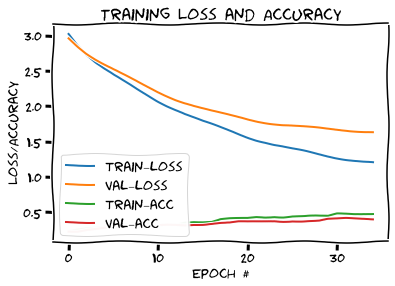

In [ ]:
# Linear model
wandb.init(project="simclr", id="linear-eval-relu-last")

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

## 14.2 Evaluate simclr with less non-linearity

In [ ]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 0s 137ms/step - loss: 3.7653 - accuracy: 0.2240 - val_loss: 3.3849 - val_accuracy: 0.2600
Epoch 2/35
2/2 [==============================] - 0s 30ms/step - loss: 3.4220 - accuracy: 0.2480 - val_loss: 3.0935 - val_accuracy: 0.2680
Epoch 3/35
2/2 [==============================] - 0s 40ms/step - loss: 3.1054 - accuracy: 0.2400 - val_loss: 2.8524 - val_accuracy: 0.2880
Epoch 4/35
2/2 [==============================] - 0s 24ms/step - loss: 2.8587 - accuracy: 0.2880 - val_loss: 2.6565 - val_accuracy: 0.3040
Epoch 5/35
2/2 [==============================] - 0s 22ms/step - loss: 2.6335 - accuracy: 0.3120 - val_loss: 2.5038 - val_accuracy: 0.3160
Epoch 6/35
2/2 [==============================] - 0s 28ms/step - loss: 2.4721 - accuracy: 0.2880 - val_loss: 2.3807 - val_accuracy: 0.3000
Epoch 7/35
2/2 [==============================] - 0s 35ms/step - loss: 2.3512 - accuracy: 0.3040 - val_loss: 2.2682 - val_accuracy: 0.2920
Epoch 8/35
2/2 [==========

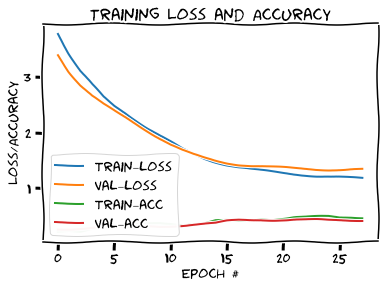

In [ ]:
wandb.init(project="simclr", id="linear-eval-relu-second-last")

linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

## 14.3 Evaluate simclr with no non-linear projections


In [ ]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 0s 145ms/step - loss: 2.4916 - accuracy: 0.1840 - val_loss: 2.3340 - val_accuracy: 0.2200
Epoch 2/35
2/2 [==============================] - 0s 31ms/step - loss: 2.3462 - accuracy: 0.1840 - val_loss: 1.6811 - val_accuracy: 0.3200
Epoch 3/35
2/2 [==============================] - 0s 26ms/step - loss: 1.7648 - accuracy: 0.2080 - val_loss: 1.7288 - val_accuracy: 0.2400
Epoch 4/35
2/2 [==============================] - 0s 25ms/step - loss: 1.6701 - accuracy: 0.3120 - val_loss: 1.6057 - val_accuracy: 0.2600
Epoch 5/35
2/2 [==============================] - 0s 25ms/step - loss: 1.5070 - accuracy: 0.3520 - val_loss: 1.3448 - val_accuracy: 0.4320
Epoch 6/35
2/2 [==============================] - 0s 30ms/step - loss: 1.3365 - accuracy: 0.4080 - val_loss: 1.2586 - val_accuracy: 0.5080
Epoch 7/35
2/2 [==============================] - 0s 26ms/step - loss: 1.3267 - accuracy: 0.4320 - val_loss: 1.2994 - val_accuracy: 0.4520
Epoch 8/35
2/2 [==========

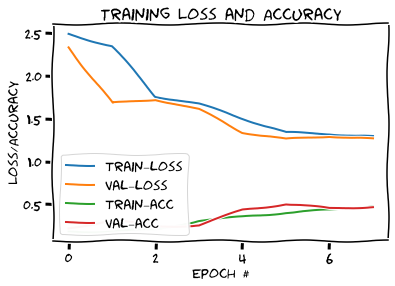

In [ ]:
wandb.init(project="simclr", id="linear-eval-no-projections")

linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

# 15.0 Visualization helpers for TSNE

In [ ]:
wandb.init(project="simclr", id="visualization")

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/akbais/simclr/runs/visualization

In [ ]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

## 15.1 TSNE visualization with no non-linear projections

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


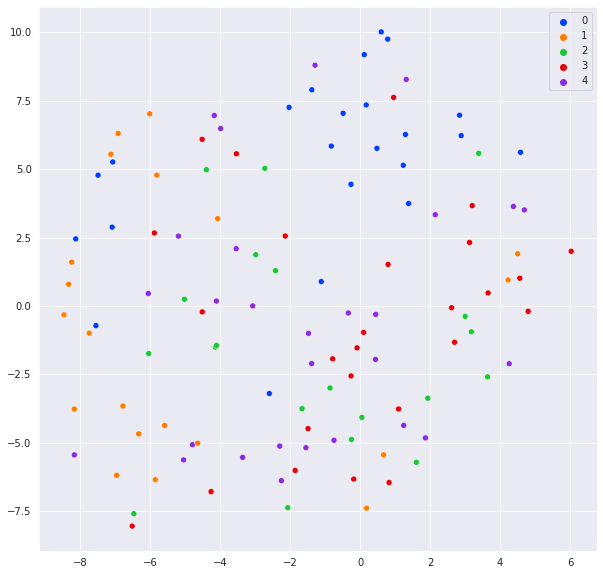

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
# Representations with no nonlinear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"no_no_linear_projection": fig})

## 15.2 TSNE visualization with less non-linearity

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



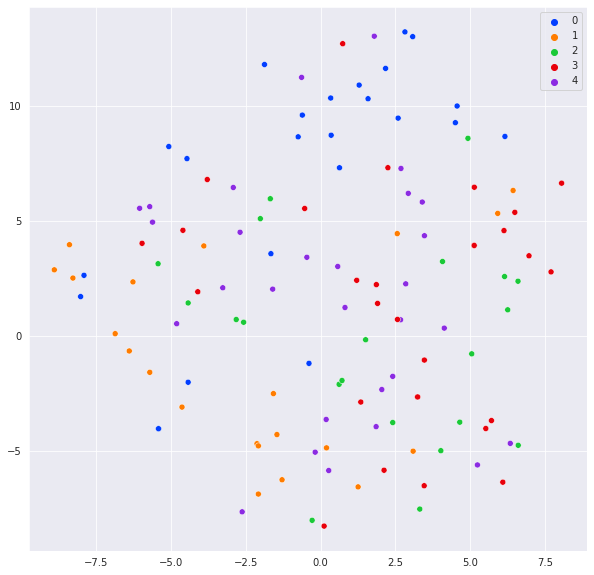

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
# Representations with second last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"second_last_relu": fig})

## 15.3 TSNE visualization with non-linear projections

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



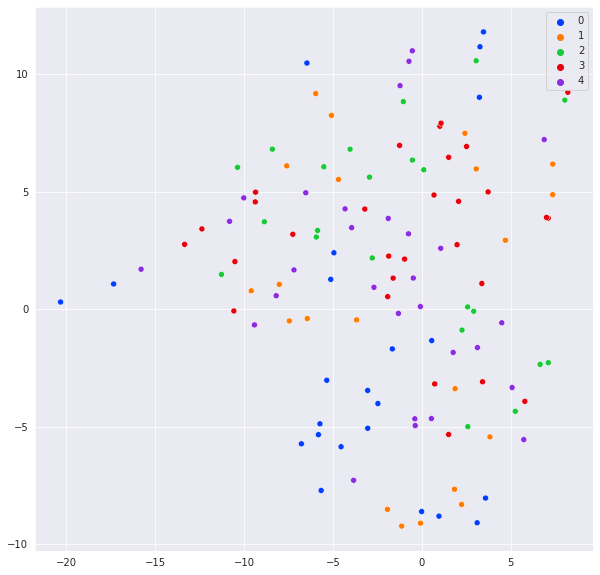

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"last_relu": fig})